# SYDE 572 Final Project
Author: Rachel Zhang
Date: December 9th, 2023


Jupter notebook was run in a Colab environment and data was uploaded to "My Drive" within google drive

In [33]:
# Import required libraries
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive
from torchvision.transforms import v2

In [34]:
# Mount Google Drive
drive.mount('/content/drive')

# Define path to data directories
train_data_path = "/content/drive/My Drive/5_shot/5_shot/train"
test_data_path = "/content/drive/My Drive/5_shot/5_shot/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Define data transforms
train_transform = v2.Compose(
    [
    # Images are originally 1020 x 530 but we need to re-shape to 224x224 (what the model expects)
    v2.ToTensor(),
    v2.Resize(224),
    # Normalize data to prevent vanishing gradient
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
    ]
)

test_transform = v2.Compose(
    [
    v2.ToTensor(),
    v2.Resize(224),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [36]:
# Write custom class to load training dataset
class TrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = self._get_file_list()

    def _get_file_list(self):
        # Get list of all file paths
        file_list = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        label = int(os.path.basename(os.path.dirname(img_path)))
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
train_dataset = TrainDataset(root_dir=train_data_path, transform=train_transform)

In [37]:
# Write custom class to load test dataset since folder does not contain labels
class TestDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.root_path = root_path
        self.transform = transform
        self.image_paths = [os.path.join(root_path, file) for file in os.listdir(root_path)]

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        # Get image file name
        image_filename = int(os.path.basename(self.image_paths[index]).split('.')[0])
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, image_filename
test_dataset = TestDataset(root_path=test_data_path, transform=test_transform)

In [38]:
# Create validation set to evaluate model
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_datasubset, validation_dataset = random_split(train_dataset, [train_size, validation_size])


In [39]:
print(f"Train images: {len(train_dataset)}")

Train images: 110


In [40]:
print(f"Train images after validation split: {len(train_datasubset)}")

Train images after validation split: 88


In [41]:
print(f"Validation images: {len(validation_dataset)}")

Validation images: 22


In [42]:
print(f"Test images: {len(test_dataset)}")

Test images: 517


In [43]:
# Create train and test data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


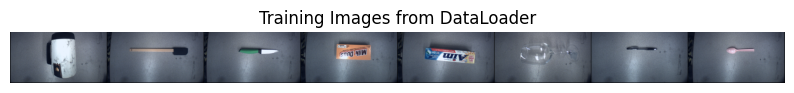

In [44]:
# Fetch a batch of images from the trainig DataLoader
for batch_idx, (images, _) in enumerate(train_loader):
    # Plot a few images from the first batch
    if batch_idx == 0:
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Training Images from DataLoader")

        # Convert images from Tensor to NumPy format and plot
        plt.imshow(
            vutils.make_grid(images[:8], padding=2, normalize=True).permute(1, 2, 0)
        )
        plt.show()
        break

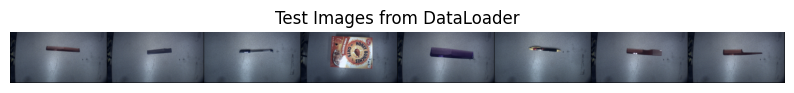

In [45]:
# Fetch a batch of images from the test DataLoader
for batch_idx, (images, _) in enumerate(test_loader):
    # Plot a few images from the first batch
    if batch_idx == 0:
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Test Images from DataLoader")

        # Convert images from Tensor to NumPy format and plot
        plt.imshow(
            vutils.make_grid(images[:8], padding=2, normalize=True).permute(1, 2, 0)
        )
        plt.show()
        break

In [46]:
# Initalize RESNET 50 model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# Change final layer to 22 classes for our classification problem
model.fc = nn.Linear(num_ftrs,22)
model.to("cuda")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
# Add optimizer and learning rate
learning_rate = 0.001
n_epochs = 20
criterion = nn.CrossEntropyLoss() # more than 2 classes therefore need this one
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [48]:
# Train the model
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = []
    accuracy_list = []

    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Back propogation
        loss.backward()
        # Update weights
        optimizer.step()
        total_loss.append(loss.item())
        accuracy_list.append(calc_accuracy(outputs, labels))

    return np.mean(total_loss), np.mean(accuracy_list)

# Validate the model
def eval_train(model, validation_loader, criterion):
    model.eval()
    total_loss = []
    accuracy_list = []

    for images, labels in validation_loader:
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = model(images)
        loss_validation = criterion(outputs, labels)
        total_loss.append(loss_validation.item())
        accuracy_list.append(calc_accuracy(outputs, labels))

    return np.mean(total_loss), np.mean(accuracy_list)

In [49]:
def calc_accuracy(model_output, target_value):
    _, predicted = torch.max(model_output, 1)
    correct = (predicted == target_value).sum().item()
    total = target_value.size(0)
    accuracy = correct / total
    return accuracy

In [50]:
def eval_model(model, test_loader):
    model.eval()
    model_predictions = []
    filenames = []
    with torch.no_grad():
        for images, file_name in test_loader:
            images, file_name = images.to("cuda"), file_name.to("cuda")

            outputs = model(images)

            _, predicted = outputs.max(1)

            model_predictions.extend(predicted.cpu().numpy())

            filenames.extend(file_name.cpu().numpy())

    return model_predictions, filenames

In [51]:
# Train the model
loss_dict = {}
loss_dict["train"] = []
loss_dict["train_accuracy"] = []
loss_dict["validation"] = []
loss_dict["validation_accuracy"] = []

validation_min_loss = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion)
    loss_dict["train"].append(train_loss)
    loss_dict["train_accuracy"].append(train_accuracy)
    val_loss, val_accuracy = eval_train(model, validation_loader, criterion)
    loss_dict["validation"].append(val_loss)
    loss_dict["validation_accuracy"].append(val_accuracy)

    # Log result after each epoch
    print('Epoch: %d/%d\t Train Loss: %.5f\t Train Accu: %.5f\t Valid Loss: %.5f\t Valid Acc: %.4f'%(epoch, n_epochs, train_loss, train_accuracy, val_loss, val_accuracy))

    # Exit training if current validation loss is lower than previous validation loss - early batching
    if val_loss < validation_min_loss:
       print('Improvement-Detected, save-model')
       torch.save(model.state_dict(), 'best_model.pth')
       validation_min_loss = val_loss

Epoch: 1/20	 Train Loss: 3.14443	 Train Accu: 0.04129	 Valid Loss: 3.02959	 Valid Acc: 0.0909
Improvement-Detected, save-model
Epoch: 2/20	 Train Loss: 3.05350	 Train Accu: 0.07254	 Valid Loss: 2.98434	 Valid Acc: 0.1364
Improvement-Detected, save-model
Epoch: 3/20	 Train Loss: 2.94096	 Train Accu: 0.26674	 Valid Loss: 2.85804	 Valid Acc: 0.5000
Improvement-Detected, save-model
Epoch: 4/20	 Train Loss: 2.79998	 Train Accu: 0.62388	 Valid Loss: 2.70455	 Valid Acc: 0.7273
Improvement-Detected, save-model
Epoch: 5/20	 Train Loss: 2.66821	 Train Accu: 0.78013	 Valid Loss: 2.50498	 Valid Acc: 0.8636
Improvement-Detected, save-model
Epoch: 6/20	 Train Loss: 2.51355	 Train Accu: 0.89397	 Valid Loss: 2.29739	 Valid Acc: 0.9545
Improvement-Detected, save-model
Epoch: 7/20	 Train Loss: 2.29826	 Train Accu: 0.99219	 Valid Loss: 2.06492	 Valid Acc: 1.0000
Improvement-Detected, save-model
Epoch: 8/20	 Train Loss: 2.15154	 Train Accu: 0.99219	 Valid Loss: 1.84806	 Valid Acc: 1.0000
Improvement-Detec

In [52]:
model.load_state_dict(torch.load('best_model.pth'))  # Load weights of the best model

test_predictions, filenames_list = eval_model(model, test_loader)

In [53]:
sorted_data = sorted(zip(filenames_list, test_predictions), key=lambda x: x[0])


In [54]:
sorted_file_names, sorted_predictions = zip(*sorted_data)

In [55]:
sorted_dict = {"id": sorted_file_names, "category": sorted_predictions}

In [56]:
import pandas as pd
sorted_df = pd.DataFrame(sorted_dict)

In [57]:
sorted_df

,id,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
512,512,21
513,513,21
514,514,21
515,515,21


In [58]:
sorted_df.to_csv('/content/drive/My Drive/sorted_predictions.csv', index=False)

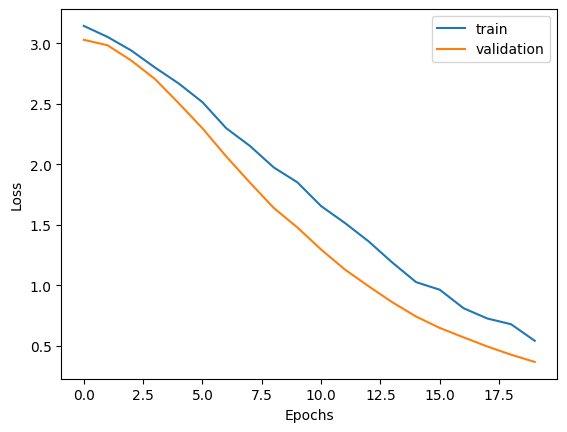

In [65]:
plt.figure()
plt.plot(range(n_epochs), loss_dict["train"], label="train")
plt.plot(range(n_epochs), loss_dict["validation"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

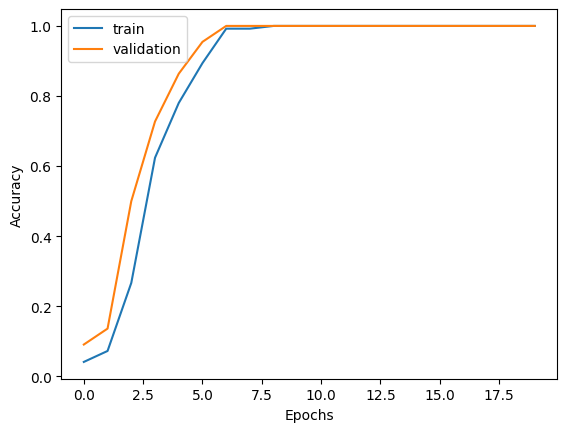

In [66]:
plt.figure()
plt.plot(range(n_epochs), loss_dict["train_accuracy"], label="train")
plt.plot(range(n_epochs), loss_dict["validation_accuracy"], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()